In [1]:
import time
import numpy as np
import statistics
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split
from absl import app
from torch.utils.tensorboard import SummaryWriter
import io
from PIL import Image
import h5py
from scipy import signal
from skimage.morphology import disk
from skimage.transform import resize

from import_files import gerate_spezific_das, log_files, bandpass, jinv_recon, n2self_mask, mask_random
from import_files import U_Net, Sebastian_N2SUNet
from unet_copy import UNet as unet
from import_files import SyntheticNoiseDAS, RealDAS
from utils_DAS import moving_window_semblance, semblance
from plots import generate_wave_plot, generate_das_plot3, generate_real_das_plot
from utils_DAS import compute_moving_coherence
import pandas as pd

In [2]:
epochs = 300 #2.000 epochen - 1 Epoche = 3424 samples
realEpochs = 100
batchsize = 32
maskChanels = 1
dasChanelsTrain = 11*maskChanels
dasChanelsVal = 11*maskChanels
dasChanelsTest = 11*maskChanels
nt = 2048

lr = 0.0001
batchnorm = False
save_model = False

gauge_length = 10
channel_spacing = 20#oder 19.2
snr = (-2,4) #(np.log(0.01), np.log(10)) for synthhetic?
slowness = (1/10000, 1/200) #(0.2*10**-3, 10*10**-3) #angabe in m/s, laut paper 0.2 bis 10 km/s     defaault: # (0.0001, 0.005)
sampling = 50.0

def load_data(strain_train_dir, strain_test_dir, nx=None):
    global dasChanelsTrain
    global dasChanelsVal
    global dasChanelsTest
    if nx:
        dasChanelsTrain = nx
        dasChanelsVal = nx
        dasChanelsTest = nx
        
    print("lade Synthetische Datensätze ...")
    #"""
    eq_strain_rates = np.load(strain_train_dir)
    # Normalise waveforms
    N_ch, N_t = eq_strain_rates.shape
    t_slice = slice(N_t//4, 3*N_t//4)
    stds = eq_strain_rates[:, t_slice].std(axis=1, keepdims=True)
    eq_strain_rates = eq_strain_rates / stds

    split_idx = int(0.8 * len(eq_strain_rates))
    eq_strain_rates_train = torch.tensor(eq_strain_rates[:split_idx])
    eq_strain_rates_val = torch.tensor(eq_strain_rates[split_idx:])

    eq_strain_rates_test = np.load(strain_test_dir)
    # Normalise waveforms
    N_ch, N_t = eq_strain_rates_test.shape
    t_slice = slice(N_t//4, 3*N_t//4)
    stds = eq_strain_rates_test[:, t_slice].std(axis=1, keepdims=True)
    eq_strain_rates_test = eq_strain_rates_test / stds



    eq_strain_rates_test = torch.tensor(eq_strain_rates_test)
    dataset = SyntheticNoiseDAS(eq_strain_rates_train, nx=dasChanelsTrain, eq_slowness=slowness, log_SNR=snr, gauge=channel_spacing, size=300*batchsize)
    dataset_validate = SyntheticNoiseDAS(eq_strain_rates_val, nx=dasChanelsVal, eq_slowness=slowness, log_SNR=snr, gauge=channel_spacing, size=30*batchsize)
    dataset_test = SyntheticNoiseDAS(eq_strain_rates_test, nx=dasChanelsTest, eq_slowness=slowness, log_SNR=snr, gauge=channel_spacing, size=30*batchsize)
    #"""
    #---------------real daten laden----------------
    #"""
    print("lade Reale Datensätze ...")
    train_path = "../Server_DAS/real_train/"
    test_path = "../Server_DAS/real_test/"
    train_path = sorted([train_path + f for f in os.listdir(train_path)])
    test_paths = sorted([test_path + f for f in os.listdir(test_path)])

    train_real_data = []
    for i, p in enumerate(train_path):
        with h5py.File(p, 'r') as hf:
            DAS_sample = hf['DAS'][81:]
            if channel_spacing == 20:
                DAS_sample = DAS_sample[::5] #if dx = 20
            train_real_data.append(DAS_sample)
    train_real_data = np.stack(train_real_data)
    gutter = 1000
    train_real_data = np.pad(train_real_data, ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
    chunks = np.array_split(train_real_data, 10)
    processed_chunks = [bandpass(chunk, low=1.0, high=10.0, fs=sampling, gutter=gutter) for chunk in chunks]
    train_real_data = np.concatenate(processed_chunks, axis=0)
    batch, N_ch, N_t = train_real_data.shape
    #effiziente for schleife (identisch zu oben mit wv)
    t_slice = slice(N_t//4, 3*N_t//4)
    stds = train_real_data[:, :, t_slice].std(axis=2, keepdims=True)
    train_real_data_all = train_real_data / stds
    train_real_data = train_real_data_all[:20,:,:]
    val_real_data = train_real_data_all[20:,:,:]

    test_real_data = []
    for i, p in enumerate(test_paths):
        with h5py.File(p, 'r') as hf:
            DAS_sample = hf['DAS'][81:]
            if channel_spacing == 20:
                DAS_sample = DAS_sample[::5] #if dx = 20
            test_real_data.append(DAS_sample)
    test_real_data = np.stack(test_real_data)
    gutter = 1000
    test_real_data = np.pad(test_real_data, ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
    chunks = np.array_split(test_real_data, 5)
    processed_chunks = [bandpass(chunk, low=1.0, high=10.0, fs=sampling, gutter=gutter) for chunk in chunks]
    test_real_data = np.concatenate(processed_chunks, axis=0)
    batch, N_ch, N_t = test_real_data.shape
    #effiziente for schleife (identisch zu oben mit wv)
    t_slice = slice(N_t//4, 3*N_t//4)
    stds = test_real_data[:, :, t_slice].std(axis=2, keepdims=True)
    test_real_data = test_real_data / stds

    real_dataset = RealDAS(train_real_data, nx=dasChanelsTrain, nt=nt, size=300*batchsize)
    real_dataset_val = RealDAS(val_real_data, nx=dasChanelsVal, nt=nt, size=20*batchsize)
    real_dataset_test = RealDAS(test_real_data, nx=dasChanelsTest, nt=nt, size=20*batchsize)
    #"""
    print("Datensätze geladen!")
    return eq_strain_rates_test,dataset,dataset_validate,dataset_test,test_real_data,real_dataset,real_dataset_val,real_dataset_test


def reconstruct(model, device, data, nx=11, nt=2048, batch_size=32, num_masked_channels=1, mask_methode='channel_1'):
    #TODO: make it work with whole batches
    #start = time.time()
    
    if "channel" in mask_methode:
        _, num_masked_channels = mask_methode.split('_')
        num_masked_channels = int(num_masked_channels)
    if "pixel" in mask_methode:
        if "jinv" in mask_methode:
            result = jinv_recon(data, model, grid_size=3, mode='interpolate', include_mask_as_input=False)
            #print(f"reconstruct jinv: {time.time()-start}")
        elif "zero" in mask_methode:
            result = jinv_recon(data, model, grid_size=3, mode='zero', include_mask_as_input=False)
            #print(f"reconstruct zero: {time.time()-start}")
        else:
            result = model(data.to(device))
            #print(f"reconstruct random: {time.time()-start}")
        return result
    data = data.squeeze(1)
    datas = data.split(1, dim=0)
    recs = []
    for das in datas:
        recs.append(channelwise_reconstruct_part(model, device, das[0], nx, nt, num_masked_channels, mask_methode)) #das.shape=(1,nx,nt)
    #print(f"reconstruct channel: {time.time()-start}")
    return torch.stack(recs).unsqueeze(1).to(device)
def channelwise_reconstruct_part_original_sebastian(model, device, data, nx, nt): # nx=11, nt=2048 
    NX, NT = data.shape
    stride = 2048

    NT_pad = (NT // stride) * stride + stride - NT
    num_patches_t = (NT - 2048) // stride + 1
    rec = torch.zeros((NX, NT))
    freq = torch.zeros((NX, NT))
    
    lower_res = int(np.floor(nx/2))
    upper_res = int(np.ceil(nx/2))
    data_pad = torch.nn.functional.pad(data, (0,0,lower_res, upper_res), mode='constant')
    
    masks = torch.ones((NX, 1, nx, nt)).to(device)
    masks[:,:,nx//2] = 0
    for i in range(num_patches_t):    
        noisy_samples = torch.zeros((NX, 1, nx, nt)).to(device)
        for j in range(NX):
            noisy_samples[j] = data_pad[j:j+nx, i*stride:i*stride + nt]
        x = (noisy_samples * masks).float().to(device)
        out = (model(x) * (1 - masks)).detach().cpu()
        rec[:, i*stride:i*stride + nt] += torch.sum(out, axis=(1,2))
        freq[:, i*stride:i*stride + nt] += torch.sum(1 - masks.detach().cpu(), axis=(1,2))

    if NT % stride != 0:
        noisy_samples = torch.zeros((NX, 1, nx, nt)).to(device)
        for j in range(NX):
            noisy_samples[j] = data_pad[j:j+nx, -nt:]
        x = (noisy_samples * masks).float().to(device)
        out = (model(x) * (1 - masks)).detach().cpu()
        rec[:, -nt:] += torch.sum(out, axis=(1,2))
        freq[:, -nt:] += torch.sum(1 - masks.detach().cpu(), axis=(1,2))
        
    rec /= freq    
    return rec

def channelwise_reconstruct_part(model, device, data, nx, nt, num_masked_channels, mask_methode): # nx=11, nt=2048
    """Args:
    model: Model to use for reconstruction
    device: Device to use for computation (gpu or cpu)
    data: noisy DAS data
    nx: channels used while training
    nt: time samples used while training
    num_masked_channels: Number of channels to mask out (default 1)
    mask_methode: Methode to mask out (default 'original')
        original: Masked chanel set to 0, like in the original version of n2self for DAS
        same: Masked channel set to random value
        self_r: Masked channel set to medium of radius r neighbours-channels
    """
    NX, NT = data.shape
    stride = 2048

    NT_pad = (NT // stride) * stride + stride - NT
    num_patches_t = (NT - 2048) // stride + 1
    rec = torch.zeros((NX, NT))
    freq = torch.zeros((NX, NT))
    
    lower_res = int(np.floor(nx/2))
    upper_res = int(np.ceil(nx/2))
    data_pad = torch.nn.functional.pad(data, (0,0,lower_res, upper_res), mode='constant') #shape=(311,2048)
    
    masks = torch.ones((NX, 1, nx, nt)).to(device) #shape=(300,1,11,2048)
    #amount of masked channels
    center_idx = nx // 2 #11//2 = 5
    half_mask = num_masked_channels // 2 #3//2 = 1
    start_idx = max(center_idx - half_mask, 0) #max(5-1,0) = 4
    end_idx = min(center_idx + half_mask + (num_masked_channels % 2), nx) #min(5+1+(3%2), 11) = 7
    # num mask chanel = 1 -> 5-6  num mask chanel = 2 -> 4-6  num mask chanel = 3 -> 4-7  num mask chanel = 4 -> 5-6
    masks[:, :, start_idx:end_idx, :] = 0
           
    if ("channel") in mask_methode:
        pass
    elif "circle" in mask_methode:    #machen mit circle und so wie im n2self paper
        _, r = mask_methode.split('_')
        r = int(r)
        if r*2 > nx:
            raise ValueError(f"radius {r} is to big for {nx} channels")
    elif "oval" in mask_methode:
        _, w, h = mask_methode.split('_')
        w = int(w)
        h = int(h)
        r = min(w,h)
        if r*2 > nx:
            raise ValueError(f"radius {r} is to big for {nx} channels")
    else:
        raise ValueError("mask_methode not known")
    #plt.imshow(masks[0][0].detach().cpu().numpy(), origin='lower', interpolation='nearest', cmap='seismic', aspect='auto')
    #plt.show()
    for i in range(num_patches_t): #1
        noisy_samples = torch.zeros((NX, 1, nx, nt)).to(device) #shape=(300,1,11,2048)
        for j in range(NX): #NX = 300
            noisy_samples[j] = data_pad[j:j+nx, i*stride:i*stride + nt] #für j = 299 ist data_pas.shape = (11, 2048)
        if "circle" in mask_methode:
            x = interpolate_disk(noisy_samples, masks, r, num_masked_channels).float().to(device)
        elif "oval" in mask_methode:
            x = interpolate_disk(noisy_samples, masks, r, maskChanels, oval_height=h, oval_width=w).float().to(device)
        elif "random" in mask_methode:
            random_values = torch.normal(0, 0.2, size=masks.shape).to(device) #shape wie noisy_samples
            x = (noisy_samples * masks + random_values*(1-masks)).float().to(device)
        else:
            x = (noisy_samples * masks).float().to(device)
        #plt.imshow(x[0][0].detach().cpu().numpy(), origin='lower', interpolation='nearest', cmap='seismic', aspect='auto')
        #plt.show()
        out = (model(x) * (1 - masks)).detach().cpu()
        rec[:, i*stride:i*stride + nt] += torch.sum(out, axis=(1,2))
        freq[:, i*stride:i*stride + nt] += torch.sum(1 - masks.detach().cpu(), axis=(1,2))

    if NT % stride != 0:
        noisy_samples = torch.zeros((NX, 1, nx, nt)).to(device)
        for j in range(NX):
            noisy_samples[j] = data_pad[j:j+nx, -nt:]
        if "circle" in mask_methode:
            x = interpolate_disk(noisy_samples, masks, r, num_masked_channels).float().to(device)
        elif "oval" in mask_methode:
            x = interpolate_disk(noisy_samples, masks, r, maskChanels, oval_height=h, oval_width=w).float().to(device)
        elif "random" in mask_methode:
            random_values = torch.normal(0, 0.2, size=masks.shape).to(device) #shape wie noisy_samples
            x = (noisy_samples * masks + random_values*(1-masks)).float().to(device)
        else:
            x = (noisy_samples * masks).float().to(device)
        out = (model(x) * (1 - masks)).detach().cpu()
        rec[:, -nt:] += torch.sum(out, axis=(1,2))
        freq[:, -nt:] += torch.sum(1 - masks.detach().cpu(), axis=(1,2))
        
    rec /= freq    
    return rec

def interpolate_disk(tensor, masks, radius, width, oval_height=None, oval_width=None):
    """From masks.py of the uppest folder used for pictures"""
    masks = masks.to(tensor.device)
    masks_inv = (1-masks).to(tensor.device)
    
    # Dynamisch den Kernel mit dem gewünschten Radius generieren
    kernel_np = n2self_mask_mit_loch_center(radius, width, oval_height, oval_width)
    kernel_np = kernel_np[np.newaxis, np.newaxis, :, :]  # Zu (1, 1, h, w) formen
    kernel_tensor = torch.Tensor(kernel_np).to(tensor.device)
    kernel_tensor = kernel_tensor / kernel_tensor.sum()

    # Repliziere den Kernel für jeden Farbkanal (c Kanäle)
    kernel_tensor = kernel_tensor.repeat(1, tensor.shape[1], 1, 1)
    filtered_tensor = torch.nn.functional.conv2d(tensor, kernel_tensor, stride=1, padding=kernel_tensor.shape[-1]//2)
    
    # Wende die Maske an: wo mask == 1 wird interpoliert, wo mask_inv == 1 bleibt der originale Wert
    return filtered_tensor * masks + tensor * masks_inv
def n2self_mask_mit_loch_center(radius, width, oval_height, oval_width):
    kernel = disk(radius).astype(np.float32)
    #if oval instead of circle
    if oval_width:
        kernel = resize(kernel, (oval_width, oval_height), mode='reflect', anti_aliasing=True)
        #make it square
        new_size = max(oval_width, oval_height)
        new_size = 2 * new_size - 1 if new_size % 2 == 0 else new_size
        new_array = np.zeros((new_size, new_size), dtype=kernel.dtype)
        start_x = (new_size - oval_width) // 2
        start_y = (new_size - oval_height) // 2
        new_array[start_x:start_x + oval_width, start_y:start_y + oval_height] = kernel
        kernel = new_array

    
    center = len(kernel) // 2
    kernel[center, center] = 0  # Setze das Zentrum auf 0
    if width == 0:
        return kernel
    kernel[center, :] = 0  # Setze den mittleren Chanel auf 0
    #Maksiere weiter Kanäle, wenn nicht nur der eine mittlere Kanal maskiert werden soll
    channel_masked = 1
    channel_to_mask = width - channel_masked
    while channel_to_mask > 0:
        if channel_masked % 2 == 0: #gerade
            #mask nach unten
            kernel[center+channel_masked/2,:] = 0
        else: #ungerade
            #mask nach oben
            kernel[center-(channel_masked//2+1),:] = 0
        channel_to_mask -= 1
    return kernel




In [3]:
strain_train_dir = "../data/DAS/SIS-rotated_train_50Hz.npy"
strain_test_dir = "../data/DAS/SIS-rotated_test_50Hz.npy"
device = "cuda" if torch.cuda.is_available() else "cpu"

eq_strain_rates_test, dataset, dataset_validate, dataset_test, test_real_data, real_dataset, real_dataset_val, real_dataset_test = load_data(strain_train_dir, strain_test_dir)
model = U_Net(1, first_out_chanel=4, scaling_kernel_size=(1,4), conv_kernel=(3,5), batchNorm=batchnorm, n2self_architecture=False).to(device)
#model.load_state_dict(torch.load("models/transfer41-n2self_channel_1_syn.pth", map_location=device))
#model.load_state_dict(torch.load("models/transfer41-n2self_pixel zero_syn_part6.pth", map_location=device))

wave = eq_strain_rates_test[6][4200:6248]
picture_DAS_syn = gerate_spezific_das(wave, nx=304, nt=2048, eq_slowness=1/(500), gauge=channel_spacing, fs=sampling)
picture_DAS_syn = picture_DAS_syn.to(device).type(torch.float32)
picture_DAS_real1 = torch.from_numpy(test_real_data[2][:1472,4576:]).to(device).type(torch.float32) #shape=1482,7424
print("fertig")

lade Synthetische Datensätze ...
lade Reale Datensätze ...
Datensätze geladen!
fertig


# synthetischer vergleich zwischen "N2self 1 kanal", "N2self Donut" und "N2self zero"

In [4]:
SNRs = [0.1, 1, 10]
all_noise_das = []
amps = []
stds = []

for SNR in SNRs:
    noise = np.random.randn(*picture_DAS_syn.shape)  # Zufälliges Rauschen
    noise = torch.from_numpy(noise).to(device).float()
    snr = 10 ** SNR
    amp = 2 * np.sqrt(snr) / torch.abs(picture_DAS_syn + 1e-10).max()
    amps.append(amp)
    clean_das = picture_DAS_syn.to(device) * amp
    noisy_das = clean_das + noise
    noisy_das = noisy_das.unsqueeze(0).unsqueeze(0).to(device).float()
    stds.append(noisy_das.std())
    all_noise_das.append(noisy_das.squeeze(0).squeeze(0))

all_noise_das = torch.stack(all_noise_das)
amps = torch.stack(amps)
stds = torch.stack(stds)
#all_semblance = semblance(all_denoised_das.unsqueeze(1).to(device))#fast implementation without moving window correction
print(all_noise_das.shape)
print(stds.shape)
print(amps.shape)

torch.Size([3, 304, 2048])
torch.Size([3])
torch.Size([3])


In [5]:
"""
clean_das_original = picture_DAS_syn
model.load_state_dict(torch.load("models/transfer41-n2self_channel_1_syn.pth", map_location=device))
mask_methode = 'channel_1'
SNRs = [0.1, 1, 10]
all_noise_das = []
all_denoised_das = []
amps = []
stds = []
if clean_das_original.shape[0] == 304:
    for SNR in SNRs:
        noise = np.random.randn(*clean_das_original.shape)  # Zufälliges Rauschen
        noise = torch.from_numpy(noise).to(device).float()
        snr = 10 ** SNR
        amp = 2 * np.sqrt(snr) / torch.abs(clean_das_original + 1e-10).max()
        amps.append(amp)
        clean_das = clean_das_original * amp
        noisy_das = clean_das + noise
        noisy_das = noisy_das.unsqueeze(0).unsqueeze(0).to(device).float()
        print((noisy_das/noisy_das.std()).shape)
        denoised_waves = reconstruct(model, device, noisy_das/noisy_das.std(), mask_methode=mask_methode, nx=dasChanelsTrain)
        all_noise_das.append(noisy_das.squeeze(0).squeeze(0))
        all_denoised_das.append((denoised_waves*noisy_das.std()).squeeze(0).squeeze(0))
    
    all_noise_das = torch.stack(all_noise_das)
    all_denoised_das = torch.stack(all_denoised_das)
    amps = torch.stack(amps)
    all_semblance = semblance(all_denoised_das.unsqueeze(1).to(device))#fast implementation without moving window correction
    ""
    all_semblance = []
    for das in all_denoised_das: #tqdm?
        all_semblance.append(torch.from_numpy(moving_window_semblance(np.swapaxes(das.cpu().numpy(), 0, 1), window=(60//channel_spacing,25))))
    all_semblance = torch.stack(all_semblance)
    ""
    #normalise for picture making
    clean_das = clean_das/amps[-1]
    all_noise_das = all_noise_das/amps[:,None,None]
    all_denoised_das = all_denoised_das/amps[:,None,None]

    das_plot_fig = generate_das_plot3(clean_das, all_noise_das, all_denoised_das, all_semblance, snr_indices=SNRs, vmin=-1, vmax=1)
    plt.show()
"""

'\nclean_das_original = picture_DAS_syn\nmodel.load_state_dict(torch.load("models/transfer41-n2self_channel_1_syn.pth", map_location=device))\nmask_methode = \'channel_1\'\nSNRs = [0.1, 1, 10]\nall_noise_das = []\nall_denoised_das = []\namps = []\nstds = []\nif clean_das_original.shape[0] == 304:\n    for SNR in SNRs:\n        noise = np.random.randn(*clean_das_original.shape)  # Zufälliges Rauschen\n        noise = torch.from_numpy(noise).to(device).float()\n        snr = 10 ** SNR\n        amp = 2 * np.sqrt(snr) / torch.abs(clean_das_original + 1e-10).max()\n        amps.append(amp)\n        clean_das = clean_das_original * amp\n        noisy_das = clean_das + noise\n        noisy_das = noisy_das.unsqueeze(0).unsqueeze(0).to(device).float()\n        print((noisy_das/noisy_das.std()).shape)\n        denoised_waves = reconstruct(model, device, noisy_das/noisy_das.std(), mask_methode=mask_methode, nx=dasChanelsTrain)\n        all_noise_das.append(noisy_das.squeeze(0).squeeze(0))\n      

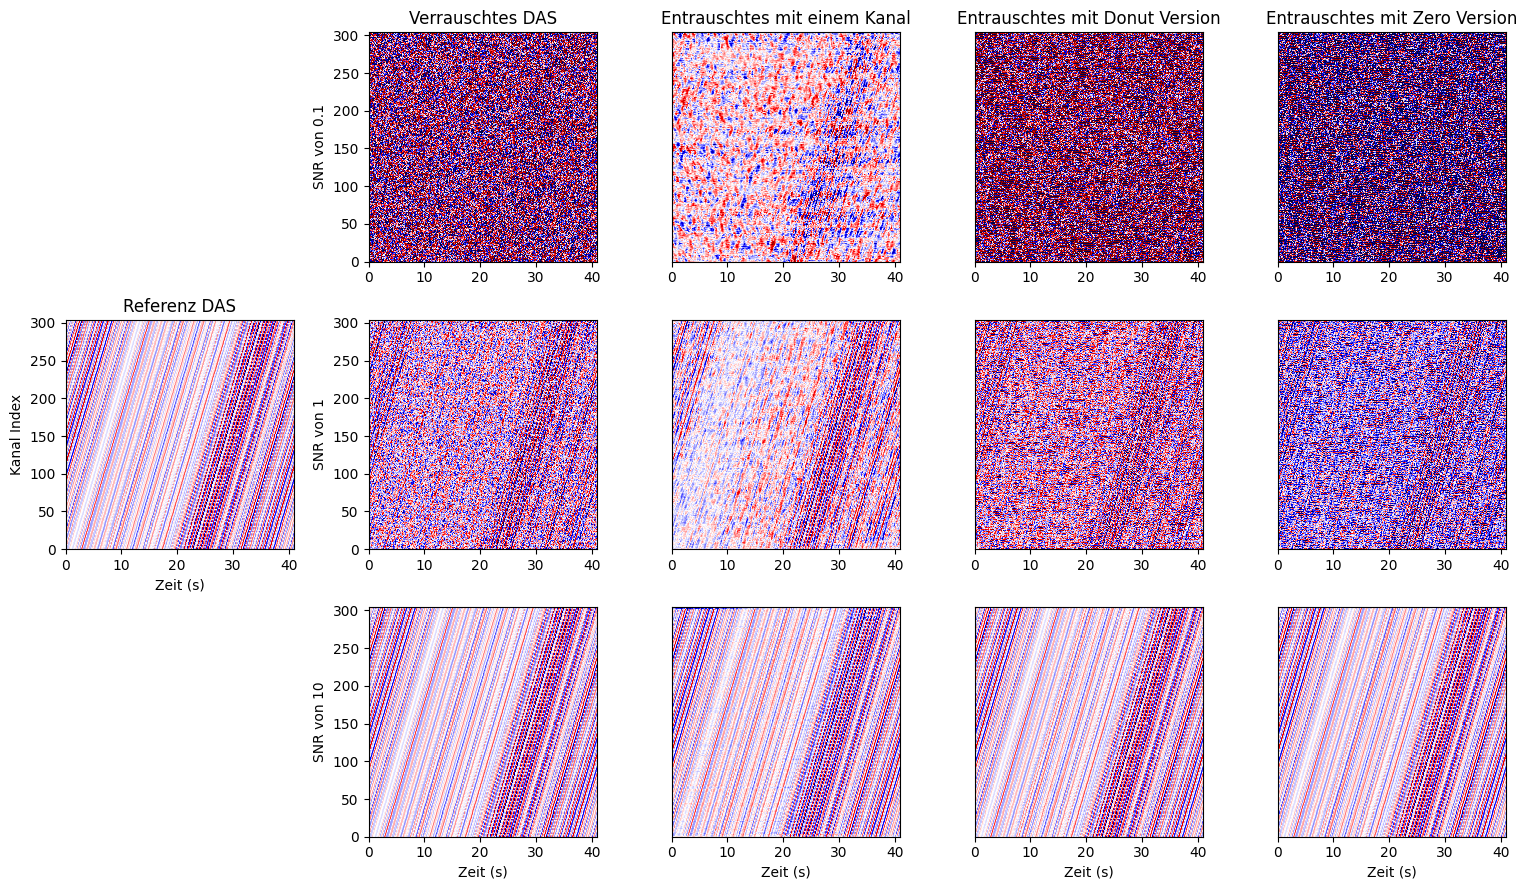

In [6]:
clean_das = picture_DAS_syn
snr_indices = [0.1, 1, 10]
vmin = -1
vmax = 1


model.load_state_dict(torch.load("models/transfer41-n2self_channel_1_syn.pth", map_location=device))
denoised_1channel_syn = reconstruct(model, device, (all_noise_das/stds[:,None,None]).unsqueeze(1), mask_methode="channel_1", nx=dasChanelsTrain).squeeze(1)
model.load_state_dict(torch.load("models/transfer41-n2self_pixel jinv_syn_part7.pth", map_location=device))
denoised_donut_syn = reconstruct(model, device, (all_noise_das/stds[:,None,None]).unsqueeze(1), mask_methode="pixel jinv", nx=dasChanelsTrain).squeeze(1)
model.load_state_dict(torch.load("models/transfer41-n2self_pixel zero_syn_part6.pth", map_location=device))
denoised_zero_syn = reconstruct(model, device, (all_noise_das/stds[:,None,None]).unsqueeze(1), mask_methode="pixel zero", nx=dasChanelsTrain).squeeze(1)

#normalise for picture making
clean_das = (clean_das/amps[-1]).cpu().detach().numpy()
clean_das = picture_DAS_syn.cpu().detach().numpy()
all_noise_das_amps = ( (all_noise_das) /amps[:,None,None]).cpu().detach().numpy()
denoised_1channel_syn = ( (denoised_1channel_syn*stds[:,None,None]) /amps[:,None,None]).cpu().detach().numpy()
denoised_donut_syn = ( (denoised_donut_syn*stds[:,None,None]) /amps[:,None,None]).cpu().detach().numpy()
denoised_zero_syn = ( (denoised_zero_syn*stds[:,None,None]) /amps[:,None,None]).cpu().detach().numpy()


# Zeitachse in Sekunden, wird mit extend geplottet
time = np.arange(clean_das.shape[-1]) / 50

# Erstelle das Grid (3 Spalten und 8 Zeilen) #verhältnis=1.7
fig, axs = plt.subplots(3, 5, figsize=(15.3, 9), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1], 'height_ratios': [1, 1, 1]})

# Spalte 1: Clean DAS (mittig, über vier Zeilen)
axs[1, 0].imshow(clean_das, extent=[time[0], time[-1], 0, clean_das.shape[-2]], aspect='auto', origin='lower', vmin=vmin, vmax=vmax, cmap='seismic', interpolation="antialiased", rasterized=True)
axs[1, 0].set_title('Referenz DAS')
axs[1, 0].set_xlabel('Zeit (s)')
axs[1, 0].set_ylabel('Kanal Index')
# Leere Felder in der ersten Spalte
axs[0, 0].set_axis_off()  # Oberes Feld leer
axs[2, 0].set_axis_off()  # Unteres Feld leer

# Spalte 2: Noisy DAS (SNR 0.1 und SNR 10 in Zeilen)
for i, snr_idx in enumerate(snr_indices):
    axs[i, 1].imshow(all_noise_das_amps[i], extent=[time[0], time[-1], 0, all_noise_das_amps.shape[-2]], aspect='auto', origin='lower', vmin=vmin, vmax=vmax, cmap='seismic', interpolation="antialiased", rasterized=True)
    axs[i, 1].set_ylabel(f'SNR von {snr_idx}')
    if i == 2:
        axs[i, 1].set_xlabel('Zeit (s)')
axs[0, 1].set_title(f'Verrauschtes DAS')

# Spalte 3: Denoised DAS (SNR 0.1 und SNR 10 in Zeilen)
for i, snr_idx in enumerate(snr_indices):
    axs[i, 2].imshow(denoised_1channel_syn[i], extent=[time[0], time[-1], 0, denoised_1channel_syn.shape[-2]], aspect='auto', origin='lower', vmin=vmin, vmax=vmax, cmap='seismic', interpolation="antialiased", rasterized=True)
    axs[i, 2].set_yticks([])
    if i == 2:# Für den untersten Plot die Linie und die Beschriftung anzeigen
        axs[i, 2].set_xlabel('Zeit (s)')
axs[0, 2].set_title(f'Entrauscht mit einem Kanal')

# Spalte 4: Denoised DAS (SNR 0.1 und SNR 10 in Zeilen)
for i, snr_idx in enumerate(snr_indices):
    axs[i, 3].imshow(denoised_donut_syn[i], extent=[time[0], time[-1], 0, denoised_donut_syn.shape[-2]], aspect='auto', origin='lower', vmin=vmin, vmax=vmax, cmap='seismic', interpolation="antialiased", rasterized=True)
    axs[i, 3].set_yticks([])
    if i == 2:# Für den untersten Plot die Linie und die Beschriftung anzeigen
        axs[i, 3].set_xlabel('Zeit (s)')
axs[0, 3].set_title(f'Entrauscht mit Donut Version')

# Spalte 5: Denoised DAS (SNR 0.1 und SNR 10 in Zeilen)
for i, snr_idx in enumerate(snr_indices):
    axs[i, 4].imshow(denoised_zero_syn[i], extent=[time[0], time[-1], 0, denoised_zero_syn.shape[-2]], aspect='auto', origin='lower', vmin=vmin, vmax=vmax, cmap='seismic', interpolation="antialiased", rasterized=True)
    axs[i, 4].set_yticks([])
    if i == 2:# Für den untersten Plot die Linie und die Beschriftung anzeigen
        axs[i, 4].set_xlabel('Zeit (s)')
axs[0, 4].set_title(f'Entrauscht mit Zero Version')
"""
#Spalte 4: Local SNR with Semblance (SNR 0.1 und SNR 10 in Zeilen)
min_color = (semblance_cpu / (1.0 - semblance_cpu)).min()
max_color = (semblance_cpu / (1.0 - semblance_cpu)).max()
for i, snr_idx in enumerate(snr_indices):
    cax = axs[i, 3].inset_axes((1.05, 0, 0.08, 1.0))
    axs[i, 3].set_yticks([])
    im = axs[i, 3].imshow(semblance_cpu[i] / (1.0 - semblance_cpu[i]),  extent=[time[0], time[-1], 0, semblance_cpu.shape[-2]], origin='lower', interpolation='nearest', vmin=min_color, vmax=max_color, cmap='viridis', aspect='auto')
    fig.colorbar(im, cax=cax, orientation='vertical')
    if i == 2:# Für den untersten Plot die Linie und die Beschriftung anzeigen
        axs[i, 3].set_xlabel('Zeit (s)')
axs[0, 3].set_title(f'Lokaler SNR')

#Spalte 5: Semblance (SNR 0.1 und SNR 10 in Zeilen)
min_color = semblance_cpu.min()
max_color = semblance_cpu.max()
for i, snr_idx in enumerate(snr_indices):
    cax = axs[i, 4].inset_axes((1.05, 0, 0.08, 1.0))
    axs[i, 4].set_yticks([])
    im = axs[i, 4].imshow(semblance_cpu[i],  extent=[time[0], time[-1], 0, semblance_cpu.shape[-2]], origin='lower', interpolation='nearest', vmin=min_color, vmax=max_color, cmap='viridis', aspect='auto')
    fig.colorbar(im, cax=cax, orientation='vertical')
    if i == 2:# Für den untersten Plot die Linie und die Beschriftung anzeigen
        axs[i, 4].set_xlabel('Zeit (s)')
axs[0, 4].set_title(f'Semblance')
"""
# Lege das Layout fest und zeige den Plot
plt.tight_layout()
plt.show()


min: -4.391410827636719 max: 3.8333542346954346


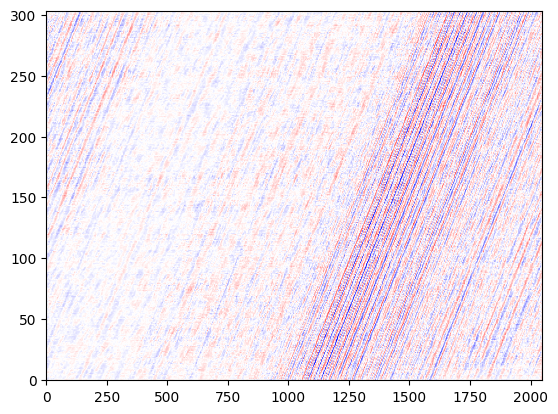

min: -14.767582893371582 max: 13.368204116821289


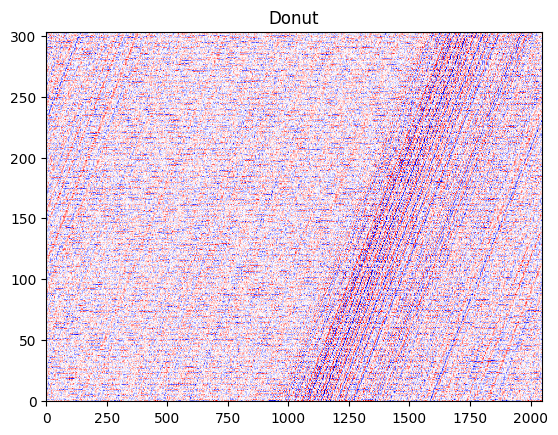

min: -13.244009971618652 max: 12.02048110961914


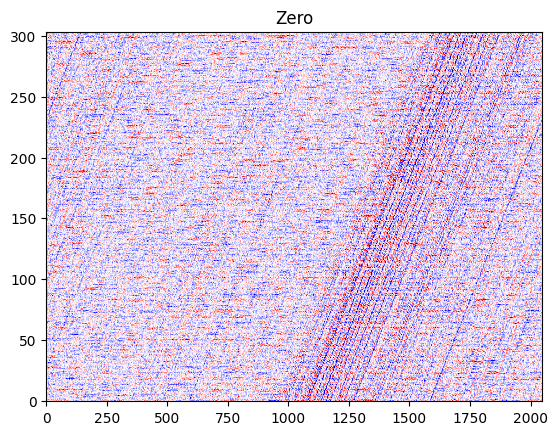

In [25]:
vmin = -1
vmax = 1
print(f"min: {denoised_1channel_syn[1].min()} max: {denoised_1channel_syn[1].max()}")
plt.imshow(denoised_1channel_syn[1], aspect='auto', origin='lower', vmin=vmin*5, vmax=vmax*5, cmap='seismic', interpolation="antialiased", rasterized=False)
plt.show()
print(f"min: {denoised_donut_syn[1].min()} max: {denoised_donut_syn[1].max()}")
plt.imshow(denoised_donut_syn[1], aspect='auto', origin='lower', vmin=vmin*5, vmax=vmax*5, cmap='seismic', interpolation="antialiased", rasterized=False)
plt.title("Donut")
plt.show()
print(f"min: {denoised_zero_syn[1].min()} max: {denoised_zero_syn[1].max()}")
plt.imshow(denoised_zero_syn[1], aspect='auto', origin='lower', vmin=vmin*5, vmax=vmax*5, cmap='seismic', interpolation="antialiased", rasterized=False)
plt.title("Zero")
plt.show()




In [31]:
#denoised_1channel_syn = torch.from_numpy(denoised_1channel_syn)
#denoised_1channel_syn = torch.from_numpy(denoised_donut_syn)
#denoised_zero_syn = torch.from_numpy(denoised_zero_syn)
clean_das = torch.from_numpy(clean_das)

In [34]:
max_intensity=clean_das.max()-clean_das.min()
mse_10 = torch.mean((clean_das-denoised_1channel_syn[0])**2)
psnr_10 = 10 * torch.log10((max_intensity ** 2) / mse_10)
mse_11 = torch.mean((clean_das-denoised_1channel_syn[1])**2)
psnr_11 = 10 * torch.log10((max_intensity ** 2) / mse_11)
mse_12 = torch.mean((clean_das-denoised_1channel_syn[2])**2)
psnr_12 = 10 * torch.log10((max_intensity ** 2) / mse_12)

mse_20 = torch.mean((clean_das-denoised_donut_syn[0])**2)
psnr_20 = 10 * torch.log10((max_intensity ** 2) / mse_20)
mse_21 = torch.mean((clean_das-denoised_donut_syn[1])**2)
psnr_21 = 10 * torch.log10((max_intensity ** 2) / mse_21)
mse_22 = torch.mean((clean_das-denoised_donut_syn[2])**2)
psnr_22 = 10 * torch.log10((max_intensity ** 2) / mse_22)

mse_30 = torch.mean((clean_das-denoised_zero_syn[0])**2)
psnr_30 = 10 * torch.log10((max_intensity ** 2) / mse_30)
mse_31 = torch.mean((clean_das-denoised_zero_syn[1])**2)
psnr_31 = 10 * torch.log10((max_intensity ** 2) / mse_31)
mse_32 = torch.mean((clean_das-denoised_zero_syn[2])**2)
psnr_32 = 10 * torch.log10((max_intensity ** 2) / mse_32)


print(f"{round(psnr_10.item(),3)} {round(psnr_20.item(),3)} {round(psnr_30.item(),3)}")
print(f"{round(psnr_11.item(),3)} {round(psnr_21.item(),3)} {round(psnr_31.item(),3)}")
print(f"{round(psnr_12.item(),3)} {round(psnr_22.item(),3)} {round(psnr_32.item(),3)}")

8.103 8.103 9.179
17.109 17.109 18.144
42.012 42.012 42.58


# reale Daten vergleich Kanal vs pixel

In [4]:
def set_bottom_line(ax, left=False):
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(left)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
# delete black outline of plot
def remove_frame(ax):
    for spine in ax.spines.values():
        spine.set_visible(False)

In [8]:
picture_DAS_real1.shape

torch.Size([1472, 7424])

In [ ]:
#1 Kanal
#model.load_state_dict(torch.load("models/transfer41-n2self_channel_1_real.pth", map_location=device))
#denoised_real_kanal = reconstruct(model, device, picture_DAS_real1.unsqueeze(0).unsqueeze(0), mask_methode='channel_1', nx=dasChanelsTrain).to('cpu').detach().numpy()
cc_clean = compute_moving_coherence(picture_DAS_real1.detach().cpu().numpy(), dasChanelsTrain) #11 weil 11 Kanäle in training?
cc_rec = compute_moving_coherence(denoised_real_kanal[0][0], dasChanelsTrain) #11 weil 11 Kanäle in training?
cc_gain_rec_kanal = cc_rec / cc_clean
print("1")
#Donut
model.load_state_dict(torch.load("models/transfer41-n2self_pixel jinv_real_part7.pth", map_location=device))
denoised_real_donut = reconstruct(model, device, picture_DAS_real1.unsqueeze(0).unsqueeze(0), mask_methode='pixel jinv', nx=dasChanelsTrain).to('cpu').detach().numpy()
cc_clean = compute_moving_coherence(picture_DAS_real1.cpu().detach().numpy(), dasChanelsTrain) #11 weil 11 Kanäle in training?
cc_rec = compute_moving_coherence(denoised_real_donut[0][0], dasChanelsTrain) #11 weil 11 Kanäle in training?
cc_gain_rec_donut = cc_rec / cc_clean
print("2")
#Zero
model.load_state_dict(torch.load("models/transfer41-n2self_pixel zero_real_part6.pth", map_location=device))
denoised_real_zero = reconstruct(model, device, picture_DAS_real1.unsqueeze(0).unsqueeze(0), mask_methode='pixel zero', nx=dasChanelsTrain).to('cpu').detach().numpy()
cc_clean = compute_moving_coherence(picture_DAS_real1.cpu().detach().numpy(), dasChanelsTrain) #11 weil 11 Kanäle in training?
cc_rec = compute_moving_coherence(denoised_real_zero[0][0], dasChanelsTrain) #11 weil 11 Kanäle in training?
cc_gain_rec_zero = cc_rec / cc_clean
print("3")

In [ ]:
clean_das = picture_DAS_real1.cpu().detach()
channel_idx_1 = 100
channel_idx_2 = 500
time = np.arange(picture_DAS_real1.shape[-1]) / 50
# Plot clean_das_original and real_denoised as imshows in one row
fig, axs = plt.subplots(3, 5, figsize=(12.5, 10), #verhältnis von 1.25
                gridspec_kw={'width_ratios': [1, 1, 0.4, 1, 0.05], 'height_ratios': [3, 1, 1]})

axs[0, 0].imshow(clean_das, origin='lower', extent=[time[0], time[-1], 0, clean_das.shape[-2]], interpolation='nearest', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs[0, 0].set_title('Reales DAS Exemplar')
axs[0, 0].set_ylabel('Kannal Index')
axs[0, 0].axhline(y=channel_idx_1, color='blue', linestyle='--', linewidth=2, label=f'Channel {channel_idx_1}')
axs[0, 0].axhline(y=channel_idx_2, color='red', linestyle='--', linewidth=2, label=f'Channel {channel_idx_2}')

axs[0, 1].imshow(denoised_real_kanal, extent=[time[0], time[-1], 0, denoised_real_kanal.shape[-2]], origin='lower', interpolation='nearest', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs[0, 1].set_title('Entrauscht mit einem Kanal')
#axs[0, 1].axhline(y=channel_idx_1, color='blue', linestyle='--', linewidth=2, label=f'Channel {channel_idx_1}')
#axs[0, 1].axhline(y=channel_idx_2, color='red', linestyle='--', linewidth=2, label=f'Channel {channel_idx_2}')
# Plot der cc-Metrik neben Semblance
gauge = 4
dist = np.arange(clean_das.shape[0]) * gauge * 1e-3
cc_ax = axs[0,1].inset_axes((1.25, 0, 0.1, 1.0))  # Neuen Bereich für die cc-Metrik neben dem Bild erstellen
cc_ax.plot(cc_gain_rec_kanal, dist, c="k")
cc_ax.axvline(1, ls=":", c="gray")
cc_ax.set_title('Kohärenzgewinn')
cc_ax.set_xlim((0, 5))
cc_ax.set_ylim((dist.max(), dist.min()))
cc_ax.yaxis.set_ticklabels([])  # Entfernt Y-Tick-Labels
cc_ax.set_yticks([])  # Entfernt Y-Ticks

axs[0, 2].imshow(denoised_real_donut, extent=[time[0], time[-1], 0, denoised_real_donut.shape[-2]], origin='lower', interpolation='nearest', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs[0, 2].set_title('Entrauscht mit Donut Version')
cc_ax = axs[0,2].inset_axes((1.25, 0, 0.1, 1.0))  # Neuen Bereich für die cc-Metrik neben dem Bild erstellen
cc_ax.plot(cc_gain_rec_kanal, dist, c="k")
cc_ax.axvline(1, ls=":", c="gray")
cc_ax.set_title('Kohärenzgewinn')
cc_ax.set_xlim((0, 5))
cc_ax.set_ylim((dist.max(), dist.min()))
cc_ax.yaxis.set_ticklabels([])  # Entfernt Y-Tick-Labels
cc_ax.set_yticks([])  # Entfernt Y-Ticks

axs[0, 3].imshow(denoised_real_zero, extent=[time[0], time[-1], 0, denoised_real_zero.shape[-2]], origin='lower', interpolation='nearest', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs[0, 3].set_title('Entrauscht mit Zero version')
cc_ax = axs[0,3].inset_axes((1.25, 0, 0.1, 1.0))  # Neuen Bereich für die cc-Metrik neben dem Bild erstellen
cc_ax.plot(cc_gain_rec_kanal, dist, c="k")
cc_ax.axvline(1, ls=":", c="gray")
cc_ax.set_title('Kohärenzgewinn')
cc_ax.set_xlim((0, 5))
cc_ax.set_ylim((dist.max(), dist.min()))
cc_ax.yaxis.set_ticklabels([])  # Entfernt Y-Tick-Labels
cc_ax.set_yticks([])  # Entfernt Y-Ticks


#axs[0, 3].imshow(semblance_das, extent=[time[0], time[-1], 0, semblance_das.shape[-2]], origin='lower', interpolation='nearest', cmap='viridis', aspect='auto')
#axs[0, 3].set_title('Semblance')
#axs[0, 3].axhline(y=channel_idx_1, color='blue', linestyle='--', linewidth=2, label=f'Channel {channel_idx_1}')
#axs[0, 3].axhline(y=channel_idx_2, color='red', linestyle='--', linewidth=2, label=f'Channel {channel_idx_2}')
#remove_frame(axs[1, 3])
#remove_frame(axs[2, 3])
#axs[1, 3].set_yticks([])
#axs[2, 3].set_yticks([])
#axs[1, 3].set_xticks([])
#axs[2, 3].set_xticks([])

#cc-skale
"""
gauge = 4
dist = np.arange(clean_das.shape[0]) * gauge * 1e-3
axs[0, 2].plot(cc_gain_rec, dist, c="k")
axs[0, 2].axvline(1, ls=":", c="gray")
axs[0, 2].set_title('Kohärnezgewinn')
axs[0, 2].set_xlim((0, 5))
axs[0, 2].set_ylim((dist.max(), dist.min()))
axs[0, 2].yaxis.set_ticklabels([])
axs[0, 2].set_yticks([])
remove_frame(axs[1, 2])
remove_frame(axs[2, 2])
axs[1, 2].set_yticks([])
axs[2, 2].set_yticks([])
axs[1, 2].set_xticks([])
axs[2, 2].set_xticks([])
"""
"""
#color bar for semblance
im = axs[0, 3].imshow(semblance_das, origin='lower', interpolation='nearest', cmap='viridis', aspect='auto')
fig.colorbar(im, cax=axs[0, 4])
remove_frame(axs[1, 4])
axs[1, 4].set_yticks([])
axs[1, 4].set_xticks([])
remove_frame(axs[2, 4]) 
axs[2, 4].set_yticks([])
axs[2, 4].set_xticks([])
"""
#Wellenform ploten
min_wave = -1
max_wave = 1
axs[1, 0].plot(time, clean_das[channel_idx_1], color='blue')
axs[1, 0].set_ylim(min_wave, max_wave)
axs[1, 0].set_ylabel(f'Kanal {channel_idx_1}')
remove_frame(axs[1, 0])  # Entferne den Rahmen
set_bottom_line(axs[1, 0], True)  # Zeige nur die untere Linie
axs[1, 0].set_yticks([])

"""
axs[1, 1].plot(time, all_denoised_das[channel_idx_1], color='blue')
axs[1, 1].set_ylim(min_wave, max_wave)
remove_frame(axs[1, 1])  # Entferne den Rahmen
set_bottom_line(axs[1, 1], True)  # Zeige nur die untere Linie
axs[1, 1].set_yticks([])

#axs[1, 3].plot(time, semblance_das[channel_idx_1], color='blue')
#axs[1, 3].set_ylim(min_wave, max_wave)
#remove_frame(axs[1, 3])  # Entferne den Rahmen
#set_bottom_line(axs[1, 3])  # Zeige nur die untere Linie
#axs[1, 3].set_yticks([])

axs[2, 0].plot(time, clean_das[channel_idx_2], color='red')
axs[2, 0].set_ylim(min_wave, max_wave)
axs[2, 0].set_ylabel(f'Kanal {channel_idx_2}')
axs[2, 0].set_xlabel('Zeit (s)')
remove_frame(axs[2, 0])  # Entferne den Rahmen
set_bottom_line(axs[2, 0], True)  # Zeige nur die untere Linie
axs[2, 0].set_yticks([])

axs[2, 1].plot(time, all_denoised_das[channel_idx_2], color='red')
axs[2, 1].set_ylim(min_wave, max_wave)
axs[2, 1].set_xlabel('Time')
remove_frame(axs[2, 1])  # Entferne den Rahmen
set_bottom_line(axs[2, 1], True)  # Zeige nur die untere Linie
axs[2, 1].set_yticks([])

#axs[2, 3].plot(time, semblance_das[channel_idx_2], color='red')
#axs[2, 3].set_ylim(min_wave, max_wave)
#axs[2, 3].set_xlabel('Time')
#remove_frame(axs[2, 3])  # Entferne den Rahmen
#set_bottom_line(axs[2, 3])  # Zeige nur die untere Linie
#axs[2, 3].set_yticks([])
"""
plt.tight_layout()
plt.show()